# Lab 03 : Graph Transformers with edge feature for regression - solution

Dwivedi, Bresson, A generalization of transformer networks to graphs, 2020   
https://arxiv.org/pdf/2012.09699.pdf

### Xavier Bresson  

<br>
Notebook goals :<br>  
• Implement graph transformers with edge feature update <br> 
• Compare performance with and without edge feature <br> 


In [1]:
# For Google Colaboratory
import sys, os
if 'google.colab' in sys.modules:
    # mount google drive
    from google.colab import drive
    drive.mount('/content/gdrive')
    path_to_file = '/content/gdrive/My Drive/GML_May23_codes/codes/07_Graph_Transformers'
    print(path_to_file)
    # change current path to the folder containing "path_to_file"
    os.chdir(path_to_file)
    !pwd
    !pip install dgl # Install DGL
    

In [2]:
# Libraries
import pickle
from utils import Dictionary, MoleculeDataset, MoleculeDGL, Molecule
import dgl
from dgl.data import MiniGCDataset
import dgl.function as fn
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torch.nn as nn
import time
import networkx as nx
from utils import compute_ncut
import os, datetime


# Load molecular datasets

In [3]:
# Select dataset
dataset_name = 'ZINC'; data_folder_pytorch = '../08_Datasets/ZINC_pytorch/'; data_folder_dgl = '../08_Datasets/ZINC_dgl/'
dataset_name = 'QM9'; data_folder_pytorch = '../08_Datasets/QM9_pytorch/'; data_folder_dgl = '../08_Datasets/QM9_dgl/'

# Load the number of atom and bond types 
with open(data_folder_pytorch + "atom_dict.pkl" ,"rb") as f: num_atom_type = len(pickle.load(f))
with open(data_folder_pytorch + "bond_dict.pkl" ,"rb") as f: num_bond_type = len(pickle.load(f))
print(num_atom_type)
print(num_bond_type)

# Load the DGL datasets
datasets_dgl = MoleculeDataset(dataset_name, data_folder_dgl)
trainset, valset, testset = datasets_dgl.train, datasets_dgl.val, datasets_dgl.test
print(len(trainset))
print(len(valset))
print(len(testset))
idx = 0
print(trainset[:2])
print(valset[idx])
print(testset[idx])


13
4
Loading datasets QM9_dgl...
train, test, val sizes : 2000 200 200
Time: 2.7305s
2000
200
200
([Graph(num_nodes=9, num_edges=20,
      ndata_schemes={'feat': Scheme(shape=(), dtype=torch.int64)}
      edata_schemes={'feat': Scheme(shape=(), dtype=torch.int64)}), Graph(num_nodes=9, num_edges=18,
      ndata_schemes={'feat': Scheme(shape=(), dtype=torch.int64)}
      edata_schemes={'feat': Scheme(shape=(), dtype=torch.int64)})], [tensor([-0.2620]), tensor([1.0906])])
(Graph(num_nodes=9, num_edges=18,
      ndata_schemes={'feat': Scheme(shape=(), dtype=torch.int64)}
      edata_schemes={'feat': Scheme(shape=(), dtype=torch.int64)}), tensor([0.5061]))
(Graph(num_nodes=9, num_edges=20,
      ndata_schemes={'feat': Scheme(shape=(), dtype=torch.int64)}
      edata_schemes={'feat': Scheme(shape=(), dtype=torch.int64)}), tensor([-4.4335]))


# Add positional encoding feature

In [4]:
# Positional encoding as Laplacian eigenvectors
def LapEig_positional_encoding(g, pos_enc_dim):
    Adj = g.adj().to_dense() # Adjacency matrix
    Dn = ( g.in_degrees()** -0.5 ).diag() # Inverse and sqrt of degree matrix
    Lap = torch.eye(g.number_of_nodes()) - Dn.matmul(Adj).matmul(Dn) # Laplacian operator
    EigVal, EigVec = torch.linalg.eig(Lap) # Compute full EVD
    EigVal, EigVec = EigVal.real, EigVec.real # make eig real
    EigVec = EigVec[:, EigVal.argsort()] # sort in increasing order of eigenvalues
    EigVec = EigVec[:,1:pos_enc_dim+1] # select the first non-trivial "pos_enc_dim" eigenvector
    return EigVec

# Add node and edge features to graphs
pos_enc_dim = 3 # dimension of PE, QM9
#pos_enc_dim = 6 # dimension of PE, ZINC
def add_node_edge_features(dataset):
    for (graph,_) in dataset:
        graph.ndata['pos_enc'] = LapEig_positional_encoding(graph, pos_enc_dim) # node positional encoding feature 
    return dataset

# Generate graph datasets
trainset = add_node_edge_features(trainset)
testset = add_node_edge_features(testset)
valset = add_node_edge_features(valset)
print(trainset[0])


(Graph(num_nodes=9, num_edges=20,
      ndata_schemes={'feat': Scheme(shape=(), dtype=torch.int64), 'pos_enc': Scheme(shape=(3,), dtype=torch.float32)}
      edata_schemes={'feat': Scheme(shape=(), dtype=torch.int64)}), tensor([-0.2620]))


# Visualize positional encoding

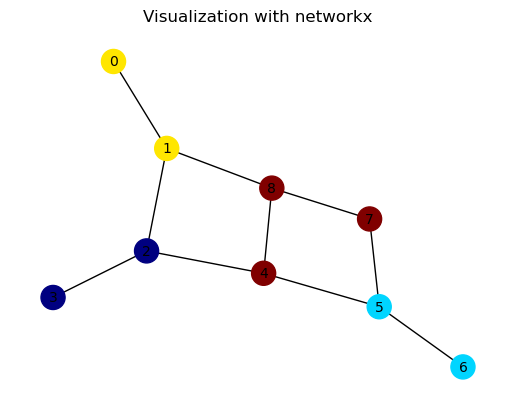

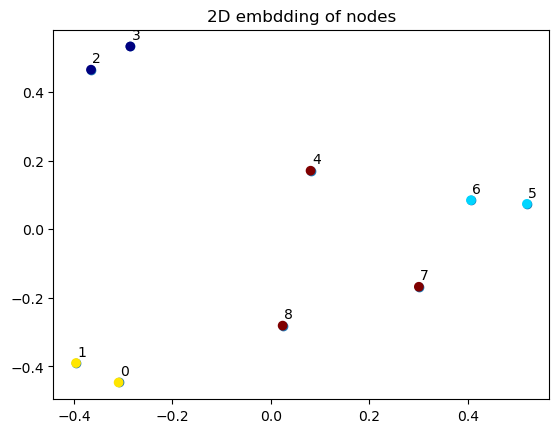

In [5]:
graph = trainset[0][0]

# Visualize graph
fig = plt.figure()
ax = fig.add_subplot(111)
Adj = graph.adj().to_dense()
A_nx = nx.from_numpy_array(Adj.numpy())
C = compute_ncut(Adj.long(), 4)
nx.draw(A_nx, ax=ax, node_color=C, cmap='jet', with_labels=True, font_size=10) # visualise node indexes
ax.title.set_text('Visualization with networkx')
plt.show()

# plot 2D coordinates
fig = plt.figure()
ax = fig.add_subplot(111)
x = graph.ndata['pos_enc']
ax.scatter(x[:,0], x[:,1])
idx = list(range(graph.number_of_nodes()))
ax.scatter(x[:,0], x[:,1], c=C, cmap='jet')
for i, txt in enumerate(idx):
    ax.annotate(txt, (x[:,0][i], x[:,1][i]), textcoords="offset points", xytext=(1,5))
ax.title.set_text('2D embdding of nodes')
plt.show()


# Define the collate function to prepare a batch of DGL graphs and test it

In [6]:
# collate function prepares a batch of graphs, labels and other graph features (if needed)
def collate(samples):
    # Input sample is a list of pairs (graph, label)
    graphs, labels = map(list, zip(*samples))
    batch_graphs = dgl.batch(graphs)    # batch of graphs
    batch_labels = torch.stack(labels)  # batch of labels (here chemical target)
    return batch_graphs, batch_labels


# Generate a batch of graphs
batch_size = 10
train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True, collate_fn=collate)
batch_graphs, batch_labels = list(train_loader)[0]
print(batch_graphs)
print(batch_labels)
batch_x = batch_graphs.ndata['feat']
print('batch_x:',batch_x.size())
batch_pe = batch_graphs.ndata['pos_enc']
print('batch_pe:',batch_pe.size())
batch_e = batch_graphs.edata['feat']
print('batch_e:',batch_e.size())


Graph(num_nodes=88, num_edges=188,
      ndata_schemes={'feat': Scheme(shape=(), dtype=torch.int64), 'pos_enc': Scheme(shape=(3,), dtype=torch.float32)}
      edata_schemes={'feat': Scheme(shape=(), dtype=torch.int64)})
tensor([[-2.8951],
        [ 0.4056],
        [ 1.3003],
        [ 2.6779],
        [-1.1444],
        [ 1.5306],
        [-0.8764],
        [ 1.2632],
        [-1.4942],
        [ 1.1754]])
batch_x: torch.Size([88])
batch_pe: torch.Size([88, 3])
batch_e: torch.Size([188])


# Design the class of GraphTransformer networks with edge feature 

Node update equation:  
\begin{eqnarray*}
\bar{h}^{\ell} &=& \textrm{BN/LN} \left( h^{\ell} + \textrm{gMHA} (h^{\ell},e^{\ell}) \right) \in \mathbb{R}^{N\times d}\\
h^{\ell+1} &=& \textrm{BN/LN} \left( \bar{h}^{\ell} + \textrm{MLP} (\bar{h}^{\ell}) \right) \in \mathbb{R}^{N\times d}\\
&&\textrm{with } \textrm{gMHA}(h,e)=\textrm{Concat}_{k=1}^H \left( \textrm{gHA}(h_k,e_k) \right) W_O \in \mathbb{R}^{N\times d},\ h_k\in \mathbb{R}^{N\times d'=d/H}, e_k\in \mathbb{R}^{E\times d'}, W_O\in \mathbb{R}^{d\times d} \\
&&\quad\quad\ \textrm{gHA}(h,e)_i= \sum_{j\in \mathcal{N}_i} \underbrace{\frac{\exp(q_i^T \textrm{diag}(e_{ij}) k_j/\sqrt{d'})}{ \sum_{j'\in\mathcal{N}_i} \exp(q_i^T \textrm{diag}(e_{ij'}) k_{j'}/\sqrt{d'}) }}_{\textrm{graph attention score w/ edge feature}_{ij}} v_j\ \textrm{ (point-wise equation)}\\
&&\quad\quad\ Q=h_k W_Q, K=h_k W_K, V=h_k W_V\in \mathbb{R}^{N\times d'=d/H}, E=e_k W_E\in \mathbb{R}^{E\times d'=d/H}, W_Q, W_K, W_N, W_E\in \mathbb{R}^{d'\times d'}\\
h^{\ell=0} &=& \textrm{LL}_1(h_0)+\textrm{LL}_2(p_0) \in \mathbb{R}^{N\times d}\ \textrm{(input node feature and positional encoding)}\\
&&\textrm{with } p_0=\Phi_{\{2,..,K+1\}}\in \mathbb{R}^{N\times K},\ \Delta = \Phi \Lambda \Phi^T \in \mathbb{R}^{N\times N}
\end{eqnarray*}

Edge update equation:  
\begin{eqnarray*}
\bar{e}^{\ell} &=& \textrm{BN/LN} \left( e^{\ell} + \textrm{gMHE} (e^{\ell},h^{\ell}) \right) \in \mathbb{R}^{E\times d}\\
e^{\ell+1} &=& \textrm{BN/LN} \left( \bar{e}^{\ell} + \textrm{MLP} (\bar{e}^{\ell}) \right) \in \mathbb{R}^{E\times d}\\
&&\textrm{with } \textrm{gMHE}(e,h)=\textrm{Concat}_{k=1}^H \left( \textrm{gHE}(e_k,h_k) \right) W_O^e \in \mathbb{R}^{E\times d},\ h_k\in \mathbb{R}^{N\times d'=d/H}, e_k\in \mathbb{R}^{E\times d'}, W_O^e\in \mathbb{R}^{d\times d} \\
&&\textrm{with } \textrm{gHE}(e,h)_{ij}=q_i \odot e_{ij} \odot k_j/\sqrt{d'} \in \mathbb{R}^{d'} \textrm{ (point-wise equation)}\\
e^{\ell=0} &=& \textrm{LL}(e_0) \in \mathbb{R}^{E\times d}\ \textrm{(input edge feature)}\\
\end{eqnarray*}

In [7]:
# Define a two-layer MLP for regression 
class MLP_layer(nn.Module): 
    
    def __init__(self, input_dim, hidden_dim): 
        super(MLP_layer, self).__init__()
        self.linear1 = nn.Linear( input_dim, hidden_dim, bias=True )
        self.linear2 = nn.Linear( hidden_dim, 1, bias=True )
        
    def forward(self, x):
        y = self.linear2(torch.relu(self.linear1(x)))
        return y

        
# class graph multi head attention layer  
class graph_MHA_layer(nn.Module): # MHA = Multi Head Attention
    
    def __init__(self, hidden_dim, head_hidden_dim, num_heads): # hidden_dim = d
        super().__init__()
        self.head_hidden_dim = head_hidden_dim # head_hidden_dim = d' = d/K
        self.num_heads = num_heads # number of heads = K
        self.WQ = nn.Linear(hidden_dim, head_hidden_dim * num_heads, bias=True) # define K x W matrix of size=(d',d')
        self.WK = nn.Linear(hidden_dim, head_hidden_dim * num_heads, bias=True)
        self.WV = nn.Linear(hidden_dim, head_hidden_dim * num_heads, bias=True)
        self.WE = nn.Linear(hidden_dim, head_hidden_dim * num_heads, bias=True)
        self.WF = nn.Linear(hidden_dim, head_hidden_dim * num_heads, bias=True)
        self.WG = nn.Linear(hidden_dim, head_hidden_dim * num_heads, bias=True)
        
    # Step 1 of message-passing with DGL: 
    #   Node feature and edge features are passed along edges (src/j => dst/i) 
    def message_func(self, edges): 
        # Compute bi-linear products with edge feature : q_i^T * diag(e_ij) * k_j 
        # You may use "edges.dst[] for i, edges.src[] for j, edges.data[] form ij" 
        qikj = (edges.src['K'] * edges.data['E'] * edges.dst['Q']).sum(dim=2).unsqueeze(2) # size=(E,K,1), edges.src/dst/data[].size=(E,K,d')
        #qikj = ### YOUR CODE HERE, size=(E,K,1), edges.src/dst/data[].size=(E,K,d')
        #qikj = (edges.src['K'] * edges.dst['Q']).sum(dim=2).unsqueeze(2) # NO edge feature
        #qikj = ### YOUR CODE HERE, NO edge feature
        expij = torch.exp( (qikj / torch.sqrt(torch.tensor(self.head_hidden_dim))).clamp(-5, 5) ) # exp_ij = exp( clamp(q_i^T * k_j / sqrt(d')) ), size=(E,K,1)
        vj = edges.src['V'] # size=(E,K,d')
        # Compute edge feature : q_i^T * diag(e_ij) * k_j
        eij = edges.src['K'] * edges.data['E'] * edges.dst['Q'] / torch.sqrt(torch.tensor(self.head_hidden_dim)) # e_ij = q_i^T * diag(E_ij) * k_j / sqrt(d'), size=(E,K,d')
        #eij = ### YOUR CODE HERE, size=(E,K,d')
        edges.data['e'] = eij # update edge feature 
        return {'expij' : expij, 'vj' : vj} 
    
    # Step 2 of message-passing with DGL: 
    #   Reduce function collects all messages={hj, eij} sent to node dst/i with Step 1
    #                   and sum/mean over the graph neigbors j in Ni
    def reduce_func(self, nodes):
        expij = nodes.mailbox['expij'] # size=(N,|Nj|,K,1), |Nj|=num_neighbors
        vj = nodes.mailbox['vj'] # size=(N,|Nj|,K,d')
        numerator = torch.sum( expij * vj, dim=1 ) # sum_j exp_ij . v_j, size=(N,K,d')
        denominator = torch.sum( expij, dim=1 ) # sum_j' exp_ij', size=(N,K,1)
        h = numerator / denominator # h_i = sum_j score_ij . v_j , where score_ij = exp_ij / sum_j' exp_ij', size=(N,K,d')
        return {'h' : h} 
    
    def forward(self, g, h, e):
        Q = self.WQ(h) # size=(N, d)
                       # computational trick to compute quickly K linear transformations h_k.WQ of size=(N, d')
                       # first compute linear transformation h.WQ of size=(N, d)
                       # then reshape h.WQ of size=(N, K, d'=d/K)
        K = self.WK(h) # size=(N, d)
        V = self.WV(h) # size=(N, d)
        E = self.WE(e) # size=(E, d)
        F = self.WF(h) # size=(N, d)
        G = self.WG(h) # size=(N, d)
        g.ndata['Q'] = Q.view(-1, self.num_heads, self.head_hidden_dim) # size=(N, K, d'=d/K)
        g.ndata['K'] = K.view(-1, self.num_heads, self.head_hidden_dim) # size=(N, K, d'=d/K)
        g.ndata['V'] = V.view(-1, self.num_heads, self.head_hidden_dim) # size=(N, K, d'=d/K)
        g.edata['E'] = E.view(-1, self.num_heads, self.head_hidden_dim) # size=(E, K, d'=d/K)
        g.ndata['F'] = F.view(-1, self.num_heads, self.head_hidden_dim) # size=(N, K, d'=d/K)
        g.ndata['G'] = G.view(-1, self.num_heads, self.head_hidden_dim) # size=(N, K, d'=d/K)
        g.update_all(self.message_func, self.reduce_func) # compute with DGL the graph MHA 
        gMHA = g.ndata['h'] # size=(N, K, d'=d/K)
        gMHE = g.edata['e'] # size=(E, K, d'=d/K)
        return gMHA, gMHE
    
    
# class GraphTransformer layer  
class GraphTransformer_layer(nn.Module):
    
    def __init__(self, hidden_dim, num_heads, norm, dropout=0.0):
        super().__init__()
        self.hidden_dim = hidden_dim # hidden_dim = d
        self.num_heads = num_heads # number of heads = K
        self.dropout = dropout # dropout value
        self.gMHA = graph_MHA_layer(hidden_dim, hidden_dim//num_heads, num_heads) # graph MHA layer
        self.WO = nn.Linear(hidden_dim, hidden_dim) # LL
        self.WOe = nn.Linear(hidden_dim, hidden_dim) # LL
        self.norm = norm # type of layer normalization
        if self.norm == 'LN': # layer normalization
            self.layer_norm1 = nn.LayerNorm(hidden_dim)
            self.layer_norm2 = nn.LayerNorm(hidden_dim)
            self.layer_norm1e = nn.LayerNorm(hidden_dim)
            self.layer_norm2e = nn.LayerNorm(hidden_dim)
        elif self.norm == 'BN': # batch normalization
            self.layer_norm1 = nn.BatchNorm1d(hidden_dim)
            self.layer_norm2 = nn.BatchNorm1d(hidden_dim)
            self.layer_norm1e = nn.BatchNorm1d(hidden_dim)
            self.layer_norm2e = nn.BatchNorm1d(hidden_dim)
        self.linear1 = nn.Linear(hidden_dim, hidden_dim) # LL1 for MLP
        self.linear2 = nn.Linear(hidden_dim, hidden_dim) # LL2 for MLP
        self.linear1e = nn.Linear(hidden_dim, hidden_dim) # LL1 for MLP
        self.linear2e = nn.Linear(hidden_dim, hidden_dim) # LL2 for MLP
        
    def forward(self, g, h, e): 
        
        # Self-attention layer
        h_rc = h # size=(N,d), V=num_nodes, for residual connection
        e_rc = e
        h_MHA, e_MHE = self.gMHA(g, h, e) # MHA, size=(N, K, d'=d/K)
        h_MHA = h_MHA.view(-1, self.hidden_dim) # size=(N, d)
        e_MHE = e_MHE.view(-1, self.hidden_dim) # size=(N, d)
        h_MHA = F.dropout(h_MHA, self.dropout, training=self.training) # dropout, size=(N, d)
        e_MHE = F.dropout(e_MHE, self.dropout, training=self.training) # dropout, size=(N, d)
        h_MHA = self.WO(h_MHA) # LL, size=(N, d)
        e_MHE = self.WOe(e_MHE) # LL, size=(N, d)
        h = h_rc + h_MHA # residual connection, size=(N, d)
        e = e_rc + e_MHE # residual connection, size=(N, d)
        h = self.layer_norm1(h) # layer normalization, size=(N, d)
        e = self.layer_norm1e(e) # layer normalization, size=(N, d)
        
        # Fully-connected layer
        h_rc = h # for residual connection, size=(N, d)
        e_rc = e # for residual connection, size=(N, d)
        h_MLP = self.linear1(h) # LL, size=(H, d)
        e_MLP = self.linear1e(e) # LL, size=(H, d)
        h_MLP = torch.relu(h_MLP) # size=(N, d)
        e_MLP = torch.relu(e_MLP) # size=(N, d)
        h_MLP = F.dropout(h_MLP, self.dropout, training=self.training) # dropout, size=(N, d)
        e_MLP = F.dropout(e_MLP, self.dropout, training=self.training) # dropout, size=(N, d)
        h_MLP = self.linear2(h_MLP) # LL, size=(N, d)
        e_MLP = self.linear2e(e_MLP) # LL, size=(N, d)
        h = h_rc + h_MLP # residual connection, size=(N, d)
        e = e_rc + e_MLP # residual connection, size=(N, d)
        h = self.layer_norm2(h) # layer normalization, size=(N, d)
        e = self.layer_norm2e(e) # layer normalization, size=(N, d)
        
        return h, e
    
    
# class Graph Transformer network
class GraphTransformer_net(nn.Module):
    
    def __init__(self, net_parameters):
        super(GraphTransformer_net, self).__init__()
        input_dim = net_parameters['input_dim']
        pos_enc_dim = net_parameters['pos_enc_dim']
        hidden_dim = net_parameters['hidden_dim']
        num_heads = net_parameters['num_heads']
        norm = net_parameters['norm'] 
        L = net_parameters['L']
        self.embedding_h = nn.Embedding(num_atom_type, hidden_dim)
        self.embedding_e = nn.Embedding(num_bond_type, hidden_dim)
        self.embedding_pe = nn.Linear(pos_enc_dim, hidden_dim)
        self.GraphTransformer_layers = nn.ModuleList([ GraphTransformer_layer(hidden_dim, num_heads, norm) for _ in range(L) ]) 
        self.MLP_layer = MLP_layer(hidden_dim, 1)
        
    def forward(self, g, h, pe, e):
        
        # input node embedding
        h = self.embedding_h(h) # size=(num_nodes, hidden_dim)
        
        # if PE used
        #h = h + self.embedding_pe(pe) # size=(num_nodes, hidden_dim)
        
        # input edge embedding
        e = self.embedding_e(e) # size=(num_edges, hidden_dim)
        
        # graph convnet layers
        for GT_layer in self.GraphTransformer_layers:
            h, e = GT_layer(g, h, e) # size=(num_nodes, hidden_dim)
        
        # MLP classifier
        g.ndata['h'] = h
        y = dgl.mean_nodes(g,'h') # DGL mean function over the neighbors, size=(num_graphs, hidden_dim)
        y = self.MLP_layer(y) # size=(num_graphs, num_classes)    
        return y    
    
    def loss(self, y_scores, y_labels):
        loss = nn.L1Loss()(y_scores, y_labels)
        return loss        
        

# Instantiate one network (testing)
net_parameters = {}
net_parameters['input_dim'] = 1
net_parameters['pos_enc_dim'] = pos_enc_dim
net_parameters['hidden_dim'] = 128
net_parameters['num_heads'] = 8
net_parameters['norm'] = 'BN' 
net_parameters['L'] = 4
net = GraphTransformer_net(net_parameters)
print(net)

batch_size = 10
train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True, collate_fn=collate)
batch_graphs, batch_labels = list(train_loader)[0]
batch_x = batch_graphs.ndata['feat']
batch_pe = batch_graphs.ndata['pos_enc']
batch_e = batch_graphs.edata['feat']
batch_labels = batch_labels
batch_scores = net(batch_graphs, batch_x, batch_pe, batch_e)
print(batch_scores.size())


GraphTransformer_net(
  (embedding_h): Embedding(13, 128)
  (embedding_e): Embedding(4, 128)
  (embedding_pe): Linear(in_features=3, out_features=128, bias=True)
  (GraphTransformer_layers): ModuleList(
    (0-3): 4 x GraphTransformer_layer(
      (gMHA): graph_MHA_layer(
        (WQ): Linear(in_features=128, out_features=128, bias=True)
        (WK): Linear(in_features=128, out_features=128, bias=True)
        (WV): Linear(in_features=128, out_features=128, bias=True)
        (WE): Linear(in_features=128, out_features=128, bias=True)
        (WF): Linear(in_features=128, out_features=128, bias=True)
        (WG): Linear(in_features=128, out_features=128, bias=True)
      )
      (WO): Linear(in_features=128, out_features=128, bias=True)
      (WOe): Linear(in_features=128, out_features=128, bias=True)
      (layer_norm1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (layer_norm2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_ru

/Users/xbresson/miniconda3/envs/gnn_course_apr23/lib/python3.8/site-packages/dgl/backend/pytorch/tensor.py:445: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  assert input.numel() == input.storage().size(), (


# Train the network

In [10]:
def run_one_epoch(net, data_loader, train=True):
    if train:
        net.train() # during training
    else:
        net.eval()  # during inference/test
    epoch_loss = 0
    nb_data = 0
    for iter, (batch_graphs, batch_labels) in enumerate(data_loader):
        batch_x = batch_graphs.ndata['feat']
        batch_pe = batch_graphs.ndata['pos_enc']
        batch_pe = batch_pe * ( 2 * torch.randint(low=0, high=2, size=(1,pos_enc_dim)).float() - 1.0 ) # randomly flip sign of eigenvectors
        batch_e = batch_graphs.edata['feat']
        batch_labels = batch_labels
        batch_scores = net.forward(batch_graphs, batch_x, batch_pe, batch_e)
        loss = net.loss(batch_scores, batch_labels)
        if train: # during training, run backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        epoch_loss += loss.detach().item()
        nb_data += batch_labels.size(0)
    epoch_loss /= (iter + 1)
    return epoch_loss 


# dataset loaders
batch_size = 50
train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True, collate_fn=collate)
test_loader = DataLoader(testset, batch_size=batch_size, shuffle=False, collate_fn=collate)
val_loader = DataLoader(valset, batch_size=batch_size, shuffle=False, drop_last=False, collate_fn=collate)

# Instantiate one network
net_parameters = {}
net_parameters['input_dim'] = 1
net_parameters['pos_enc_dim'] = pos_enc_dim
net_parameters['hidden_dim'] = 128
net_parameters['num_heads'] = 8
net_parameters['norm'] = 'BN' 
net_parameters['L'] = 4
del net
net = GraphTransformer_net(net_parameters)

# # save initial net for comparison
# checkpoint_dir = os.path.join("checkpoint")
# if not os.path.exists(checkpoint_dir):
#     os.makedirs(checkpoint_dir)
# time_stamp = datetime.datetime.now().strftime("%y-%m-%d--%H-%M-%S")
# #torch.save({'net_init': net.state_dict(),}, '{}.pkl'.format(checkpoint_dir + "/checkpoint_" + "ZINC_" + time_stamp ))
# torch.save({'net_init': net.state_dict(),}, '{}.pkl'.format(checkpoint_dir + "/checkpoint_" + "QM9_" + time_stamp ))

# load initial net for comparison
checkpoint_file = "checkpoint/checkpoint_QM9_23-05-07--12-43-01.pkl"
checkpoint = torch.load(checkpoint_file)
net.load_state_dict(checkpoint['net_init'])
del checkpoint

# optimizer
optimizer = torch.optim.Adam(net.parameters(), lr=0.0003)

# training loop
start = time.time()
for epoch in range(15):
    epoch_train_loss = run_one_epoch(net, train_loader, True)
    with torch.no_grad(): 
        epoch_test_loss = run_one_epoch(net, test_loader, False)
        epoch_val_loss = run_one_epoch(net, val_loader, False)  
    print('Epoch {}, time {:.4f}, train_loss: {:.4f}, test_loss: {:.4f}, val_loss: {:.4f}'.format(epoch, time.time()-start, epoch_train_loss, epoch_test_loss, epoch_val_loss))
    

Epoch 0, time 3.5131, train_loss: 1.3346, test_loss: 1.2535, val_loss: 1.1561
Epoch 1, time 6.7691, train_loss: 1.2669, test_loss: 1.2039, val_loss: 1.1113
Epoch 2, time 10.3584, train_loss: 1.2324, test_loss: 1.1567, val_loss: 1.0669
Epoch 3, time 13.7182, train_loss: 1.2093, test_loss: 1.2073, val_loss: 1.0984
Epoch 4, time 17.0723, train_loss: 1.1978, test_loss: 1.1398, val_loss: 1.0696
Epoch 5, time 20.3562, train_loss: 1.1787, test_loss: 1.1375, val_loss: 1.0430
Epoch 6, time 23.7448, train_loss: 1.1680, test_loss: 1.0924, val_loss: 1.0480
Epoch 7, time 26.9114, train_loss: 1.1676, test_loss: 1.0864, val_loss: 1.0423
Epoch 8, time 30.1197, train_loss: 1.1419, test_loss: 1.0865, val_loss: 1.0132
Epoch 9, time 33.2233, train_loss: 1.1378, test_loss: 1.1378, val_loss: 1.0924
Epoch 10, time 36.2970, train_loss: 1.1382, test_loss: 1.0667, val_loss: 1.0160
Epoch 11, time 39.4832, train_loss: 1.1227, test_loss: 1.0736, val_loss: 0.9958
Epoch 12, time 42.5499, train_loss: 1.1206, test_los

In [9]:
# QM9 Results 

# Edge feature
# Epoch 14, time 47.2540, train_loss: 1.0907, test_loss: 1.0534, val_loss: 0.9784
# Epoch 14, time 47.5533, train_loss: 1.1071, test_loss: 1.0493, val_loss: 0.9724
# Epoch 14, time 47.5198, train_loss: 1.1018, test_loss: 1.0532, val_loss: 0.9750
            
# NO Edge feature
# Epoch 14, time 40.9383, train_loss: 1.1687, test_loss: 1.1074, val_loss: 1.0200
# Epoch 14, time 41.9198, train_loss: 1.1695, test_loss: 1.1214, val_loss: 1.0261
# Epoch 14, time 42.8492, train_loss: 1.1786, test_loss: 1.1345, val_loss: 1.0346
            